In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [100]:
LOG_DIR = './ops_logs'
TIMESTEPS = 20
TRAINING_STEPS = 10000
BATCH_SIZE = 100
PRINT_STEPS = TRAINING_STEPS / 10
INPUTS = 1
NEURONS = 20
OUTPUTS = 1
LEARNING_RATE = 0.003

In [101]:
def rnn_data(data, time_steps):
    """
    Teilt die Daten in time_steps Portionen auf
    """
    rnn_df = []
    for i in range(len(data) - time_steps):
        data_ = data.iloc[i: i + time_steps].as_matrix()
        rnn_df.append(data_ if len(data_.shape) > 1 else [[i] for i in data_])
    return np.array(rnn_df)


def split_data(data, val_size=0.1, test_size=0.1):
    """
    Teilt die Daten in Trainings-, Test- und einen Validierungsteil
    """
    ntest = int(round(len(data) * (1 - test_size)))
    nval = int(round(len(data.iloc[:ntest]) * (1 - val_size)))

    df_train, df_val, df_test = data.iloc[:nval], data.iloc[nval:ntest], data.iloc[ntest:]

    return df_train, df_val, df_test


def prepare_data(data, time_steps, val_size=0.05, test_size=0.05):
    """
    Bereitet die Training- Test- und Validierungsdaten vor
    """
    df_train, df_val, df_test = split_data(data, val_size, test_size)
    return (rnn_data(df_train, time_steps),
            rnn_data(df_val, time_steps),
            rnn_data(df_test, time_steps))


def load_csvdata(rawdata, time_steps, seperate=False):
    """
    Erzeug Trainings-, Test- und Validierungsdaten in Form eines DataFrame
    """
    data = rawdata
    train_x, val_x, test_x = prepare_data(data['a'] if seperate else data, time_steps)
    return dict(train=train_x, val=val_x, test=test_x)


In [102]:
# Parser für das Datumsformat
dateparse = lambda dates: pd.datetime.strptime(dates, '%d/%m/%Y %H:%M')

# Daten einlesen
rawdata = pd.read_csv("/tmp/RealMarketPriceDataPT.csv", 
                   parse_dates={'timeline': ['date', '(UTC)']}, 
                   index_col='timeline', date_parser=dateparse)

# CSV Daten aufteilen
x_data = load_csvdata(rawdata, TIMESTEPS, seperate=False)

In [103]:
# Die Daten liegen jetzt in Form von 'train', 'test' und 'val' vor
print('x_test : ', len(x_data['test']))
print('x_train : ', len(x_data['train']))
print('x_val : ', len(x_data['val']))

('x_test : ', 559)
('x_train : ', 10440)
('x_val : ', 531)


In [104]:
# Daten haben die Form (Anzahl_Gesamt, Teil, Wert)
print(x_data['train'].shape)

(10440, 20, 1)


In [105]:
def next_batch(batch_size, n_steps, data):
    """
    Liefert per Zufall zwei Datensätze zurück, welche n_steps groß sind und um einen Wert
    verschoben sind.
    """
    idx = np.arange(0, len(data))  
    np.random.shuffle(idx)  
    idx = idx[0:n_steps]  
    data_shuffle = [data[i] for i in idx]  
    data_shuffle = np.asarray(data_shuffle)  
    return data_shuffle[:, 1:].reshape(-1, n_steps, 1), data_shuffle[:, 1:].reshape(-1, n_steps, 1)

In [106]:
# Die Trainigsdaten sehen wie folgt aus
x_train, y_train = next_batch(BATCH_SIZE, TIMESTEPS, x_data['train'])
# Es ist immer ein Tageswert versetzt
np.c_[x_train[1], y_train[1]]

array([[ 23.55,  23.55],
       [ 30.  ,  30.  ],
       [ 37.7 ,  37.7 ],
       [ 39.25,  39.25],
       [ 41.7 ,  41.7 ],
       [ 39.02,  39.02],
       [ 38.  ,  38.  ],
       [ 37.7 ,  37.7 ],
       [ 37.7 ,  37.7 ],
       [ 35.68,  35.68],
       [ 32.  ,  32.  ],
       [ 36.8 ,  36.8 ],
       [ 38.5 ,  38.5 ],
       [ 41.39,  41.39],
       [ 42.1 ,  42.1 ],
       [ 52.56,  52.56],
       [ 60.7 ,  60.7 ],
       [ 60.95,  60.95],
       [ 30.33,  30.33],
       [ 26.1 ,  26.1 ]])

In [107]:
# TensorFlow Default Graph zurücksetzen
tf.reset_default_graph()

# Placeholder für die Eingabe- und Ausgabe-Daten
X = tf.placeholder(tf.float32, [None, TIMESTEPS, INPUTS])
y = tf.placeholder(tf.float32, [None, TIMESTEPS, OUTPUTS])

cell = tf.contrib.rnn.BasicRNNCell(num_units=NEURONS, activation=tf.nn.relu)
output_projection_cell = tf.contrib.rnn.OutputProjectionWrapper(cell, output_size=OUTPUTS)
outputs, states = tf.nn.dynamic_rnn(output_projection_cell, X, dtype=tf.float32)

loss = tf.reduce_sum(tf.square(outputs - y))
optimizer = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE)
#optimizer = tf.train.AdagradOptimizer(learning_rate=0.005,initial_accumulator_value=0.1)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [108]:
y_pred = []
x_test, y_test = next_batch(1, TIMESTEPS, x_data['test'])

In [109]:
saver = tf.train.Saver()
with tf.Session() as sess:
    init.run()
    for iteration in range(TRAINING_STEPS):
        x_batch, y_batch = next_batch(BATCH_SIZE, TIMESTEPS, x_data['train'])
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch})
        if iteration % PRINT_STEPS == 0:
            mse = loss.eval(feed_dict={X: x_batch, y: y_batch})
            print(iteration, "MSE: %f" % mse)
    
    y_pred = sess.run(outputs, feed_dict={X: x_test})
    save_path = saver.save(sess, "./timeseries-model.ckpt")
    print("Model saved in file: %s" % save_path)

(0, 'MSE: 1077607.875000')
(1000, 'MSE: 16.455349')
(2000, 'MSE: 42.021446')
(3000, 'MSE: 45.631641')
(4000, 'MSE: 18.862907')
(5000, 'MSE: 13.761512')
(6000, 'MSE: 2.801513')
(7000, 'MSE: 8.056877')
(8000, 'MSE: 2.722856')
(9000, 'MSE: 2.135699')
Model saved in file: ./timeseries-model.ckpt


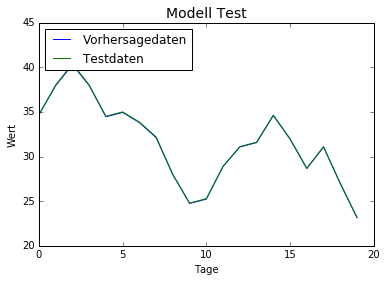

In [110]:
plt.title("Modell Test", fontsize=14)
plt.plot(y_pred[0,:,0], label="Vorhersagedaten")
plt.plot(x_test[0,:,0], label="Testdaten")
plt.xlabel("Tage")
plt.ylabel("Wert")
plt.legend(loc="upper left")
plt.show()